In [1]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, Game, simulate_1p_game, simulate_1p_game_with_data
import matplotlib.pyplot as plt
from itertools import repeat
import sys
%matplotlib inline

Drawing...


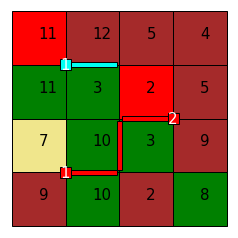

In [2]:
width, height = 4,4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources, {6:0, 16:1}, {13:0}, {(6, 7):0, (7, 12):0, (12, 13):0, (16,17): 1})
board.register_player()
board.register_player()
board.draw()

In [3]:
def action(self):
    goal = determine_goal(board, self)
    
    if self.get_settlements() == [] and self.if_can_buy("settlement"):
        (x,y) = self.preComp
        self.buy("settlement", x, y) # we determined previously    
        print("bought settlement at " + "(" + str(x) + "," + str(y) + ")")         
    
    if goal == "settlement":
        (x, y) = optimal_settlement(self)
        print((x, y))
        if self.board.get_vertex_number(x, y) in [v for road in self.get_roads() for v in road]:
            if self.if_can_buy("settlement"):    
                self.buy("settlement", x, y)
                print("bought settlement at " + "(" + str(x) + "," + str(y) + ")") 
        elif len(self.get_settlements()) > 0 and self.if_can_buy("road"): 
                (v0, v1) = optimal_road(self, (x, y))
                self.buy("road", v0, v1)
                print("bought road " + str(v0) + str(v1))
        elif self.resources[np.argmax(self.resources)] >= 4:
            rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
            self.trade(rmax,rmin)
            print("traded " + str(rmax) + " for " + str(rmin))
#         else:
#             modified_trade(self, goal)

    elif goal == "city":
        if self.if_can_buy("city"):
            (x, y) = optimal_city(self)
            self.buy("city", x, y)
            print("bought city")              
    elif goal == "card":
        if self.if_can_buy("card"):
            self.buy("card")
            print("bought card")   
        elif self.resources[np.argmax(self.resources)] >= 4:
            rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
            self.trade(rmax,rmin)
            print("traded " + str(rmax) + "for " + str(rmin))            
#         else:
#             modified_trade(self, goal)
            
    return

In [4]:
def determine_goal(board, self):
    buildings = ["settlement", "city", "card"]
    goal = "card"
    max_value = 0
    for building in buildings:
        time = hitting_time(board, building)
#         usefulness = determine_usefulness(board, building, self)
        usefulness = 0
        curr_value = 1/time + usefulness
        if curr_value > max_value:
            goal = building
            max_value = curr_value
    
    return goal

In [5]:
def hitting_time(board, building):
    if building == "settlement":
        return 5
    elif building == "card":
        return np.random.randint(4, 7)
    elif building == "city":
        return np.random.randint(3, 6)

# def determine_usefulness(board, building, self):
    

In [6]:
def dumpPolicy(self, max_resources):
    print("dumped")
    new_resources = np.minimum(self.resources, max_resources // 3)
    return self.resources - new_resources

In [7]:
def planBoard(baseBoard):
    return baseBoard.get_vertex_location(np.argmax(settlement_scores))

In [8]:
def optimal_settlement(self):

    opt_set_loc = 0
    max_score = 0
    A = 5 #A is just some weight    
    
    for row in range(self.board.height + 1):
        for col in range(self.board.width + 1):
            curr_settlement = (col, row)
            if self.board.if_can_build("settlement", curr_settlement[0], curr_settlement[1]):
                dist = get_closest(self, curr_settlement)[1]            
                score = settlement_scores[row][col] + A / (dist+0.01)

                if score > max_score:
                    opt_set_loc = curr_settlement
                    max_score = score
    return opt_set_loc

In [9]:
def get_closest(self, goal):
    curr_settlements = self.get_settlements()
    curr_roads = self.get_roads()    
    closest = 0
    closest_dist = 500
    for s in curr_settlements:
        coordinates = self.board.get_vertex_location(s)
        dist = abs(goal[0] - coordinates[0]) + abs(goal[1] - coordinates[1])
        if dist < closest_dist:
            closest = s
            closest_dist = dist
    
    for r in curr_roads:
        for end in r:
            r_end = self.board.get_vertex_location(end)
            dist = abs(goal[0] - r_end[0]) + abs(goal[1] - r_end[1])
            if dist < closest_dist:
                closest = end
                closest_dist = dist
    
    return (closest, closest_dist)

In [10]:
def optimal_road(self, goal):
    curr_settlements = self.get_settlements()
    curr_roads = self.get_roads()
    
    closest = get_closest(self, goal)[0]
    hor = goal[0] - self.board.get_vertex_location(closest)[0]
    ver = goal[1] - self.board.get_vertex_location(closest)[1]    
    v2 = closest
    
    if abs(hor) >= abs(ver):
        if hor < 0:
            v2 -= 1
        elif hor > 0:
            v2 += 1
    else:
        if ver < 0:
            v2 -= 5
        else:
            v2 += 5
    
    return (self.board.get_vertex_location(closest), self.board.get_vertex_location(v2))

In [11]:
def optimal_city(self):
    opt_s = self.preComp
    val = 0
    for settlement in self.get_settlements():
        s = self.board.get_vertex_location(settlement)
        score = settlement_scores[s[1]][s[0]]
        print(score)
        if score > val:
            val = score
            opt_s = s
    return opt_s

In [12]:
def modified_trade(self, goal):
    ports = [] #get list of ports and everything thats in it    

    for e in self.get_settlements():
        if self.board.is_port(e):
            ports.append(self.board.which_port(e))
    for e in self.get_cities():
        if self.board.is_port(e):
            ports.append(self.board.which_port(e))

    trade_away = -1 
    trade_for = -1
    curr_best = hitting_time(self.resources, goal) #find hitting time of current state
    trade = False
    subtract = 0 

    for i in range(len(self.resources)):
        required = 4 #start off needing 4 resources for each
        if i in ports: #seeing how many required to trade
            required = 2
        if 3 in ports:
            required = min(required, 3)
        if self.resources[i] >= required: #if have enough, try combinations of trading
            for j in range(len(self.resources)): 
                if i == j:
                    continue
                potential = self.resources[:]#added in to make a copy of actual resources
                potential[i] -= required #performs trade
                potential[j] += 1
                new_time = hitting_time(potential, goal) #calculates new hitting time
                if new_time < curr_best:
                    curr_best = new_time 
                    trade_away = i
                    trade_for = j
                    trade = True
                    subtract = required
    if trade:
        self.resources[trade_away] -= subtract
        self.resources[trade_for] += 1

In [13]:
RESOURCE_SCORES = {0: 4/17, 1: 7/17, 2: 6/17, -1: 0}  ## MAKE SURE THESE ARE RIGHT. SHOULD BE WOOD BRICK GRAIN
# RESOURCE_SCORES = {0: 1, 1: 1, 2: 1, -1: 0}  ## MAKE SURE THESE ARE RIGHT. SHOULD BE WOOD BRICK GRAIN
RESOURCE_WEIGHT = 3 # FOR TESTING
DICE_SCORES = {2: 1/15, 12: 1/15, 3: 2/15, 11: 2/15, 4: 3/15, 10: 3/15, 5: 4/15, 9: 4/15, 6: 5/15, 8: 5/15, 7: 0}
DICE_WEIGHT = 15 # FOR TESTING


# Returns 2D array of board scores
def make_board_scores(board):
    scoreboard = [[] for _ in range(len(board.dice))]
    for i in range(len(board.dice)):
        for j in range(len(board.dice[0])):
            calculate_tile_score
            scoreboard[i].append(calculate_tile_score(board, i, j))
            
    return np.array(scoreboard)

# Calculate the score of tile i, j on the board
def calculate_tile_score(board, i, j):
    resource_score = RESOURCE_SCORES[board.resources[i][j]]
    dice_score = DICE_SCORES[board.dice[i][j]]
    
    return resource_score * RESOURCE_WEIGHT + dice_score * DICE_WEIGHT


def make_settlement_scores(board, board_scores):
    scoreboard = [[] for _ in range(len(board.dice) + 1)]
    
    for i in range(len(scoreboard)):
        for j in range(len(board.dice[0]) + 1):
            scoreboard[i].append(get_settlement_score(board, board_scores, i, j))
    return np.array(scoreboard)

def get_settlement_score(board, board_scores, i, j):
    PORT_WEIGHT = .5
    if i == 0 or i == len(board_scores):
        if i == len(board_scores):  # To make indices line up
            i -= 1
            
        if j == 0:
            return board_scores[i][j] + PORT_WEIGHT
        elif j == len(board_scores[0]):
            return board_scores[i][j-1] + PORT_WEIGHT
        else:
            return board_scores[i][j] + board_scores[i][j-1]
    elif j == 0 or j == len(board_scores[0]):
        if j == len(board_scores[0]): # To make indices line up
            j -= 1
            
        if i == len(board_scores):
            return board_scores[i-1][j] + PORT_WEIGHT
        else:
            return board_scores[i-1][j] + board_scores[i][j]
    elif i == len(board_scores) and j == len(board_scores[0]):
        return board_scores[i-1][j-1] + PORT_WEIGHT
    else:
        return board_scores[j][i] + board_scores[j-1][i] + board_scores[j][i-1] + board_scores[j-1][i-1]
        

board_scores = make_board_scores(board)
print(board.dice)
print(board_scores)
settlement_scores = make_settlement_scores(board, board_scores)
print(settlement_scores)

[[ 9 10  2  8]
 [ 7 10  3  9]
 [11  3  2  5]
 [11 12  5  4]]
[[4.70588235 4.05882353 1.70588235 6.05882353]
 [0.         4.05882353 3.05882353 4.70588235]
 [3.05882353 3.05882353 2.23529412 4.70588235]
 [3.23529412 1.70588235 4.70588235 3.70588235]]
[[ 5.20588235  8.76470588  5.76470588  7.76470588  6.55882353]
 [ 4.70588235 12.82352941 10.17647059 11.05882353 10.76470588]
 [ 3.05882353 12.88235294 12.41176471 11.70588235  9.41176471]
 [ 6.29411765 15.52941176 14.70588235 15.35294118  8.41176471]
 [ 3.73529412  4.94117647  6.41176471  8.41176471  4.20588235]]


In [14]:
settlements, cities, roads, hands, live_points, dice_rolls = simulate_1p_game_with_data(action, dumpPolicy, planBoard, board)

def draw(t):
    t = int(t)
    live_board = Catan(board.dice, board.resources, [], [])
    live_board.settlements = settlements[t]
    live_board.cities = cities[t]
    live_board.roads = roads[t]
    print("turn:", t)
    print("points:", live_points[t])
    print("dice roll:", dice_rolls[t])
    print("resources:", hands[t])
    live_board.draw()
    
    board_scores = make_board_scores(board)
    print(board.dice)
    print(board_scores)
    settlement_scores = make_settlement_scores(board, board_scores)
    print(settlement_scores)

bought settlement at (1,3)
(3, 3)
bought road (1, 3)(2, 3)
(3, 3)
bought road (2, 3)(3, 3)
(3, 3)
(3, 3)
(3, 3)
traded 2for 0
(3, 3)
(3, 3)
(3, 3)
bought settlement at (3,3)
(2, 2)
15.529411764705882
15.352941176470587
bought city
(2, 2)
(2, 2)
traded 0 for 1
(2, 2)
bought road (2, 3)(2, 2)
(2, 2)
(2, 2)
bought settlement at (2,2)
(1, 1)
bought road (2, 2)(1, 2)
15.352941176470587
12.411764705882351
bought city
(1, 1)
traded 0 for 1
traded 0for 1
(1, 1)
bought road (1, 2)(1, 1)
traded 0for 1
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
bought settlement at (1,1)
12.411764705882351
12.823529411764707
bought city
traded 0for 2
12.411764705882351
bought city
bought settlement at (1,3)
bought settlement at (1,3)
bought city
bought settlement at (1,3)
bought city
bought settlement at (1,3)
bought city
bought settlement at (1,3)
(3, 1)
traded 0 for 1
bought settlement at (1,3)
(3, 1)
traded 0 for 2
bought settlement at (1,3)
bought city
bought settlement at (1,3)
bought city
bought settlement at (1,3)

In [15]:
from ipywidgets import *
interact(draw, t=(0, len(live_points) - 1, 1))

interactive(children=(IntSlider(value=49, description='t', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.draw(t)>

In [16]:
# board.draw()
# print(board.get_resources())

# # wood is brown, brick is red, grain is green 
# # below is the resource outcome of a dice roll 2-12

In [17]:
# num_trials = 3

# width, height = 4, 4
# dice = get_random_dice_arrangement(width, height)
# resources = np.random.randint(0, 3, (height, width))
# board = Catan(dice, resources)
# print("average turns to win: {}".format(simulate_1p_game(action, dumpPolicy, planBoard, board, num_trials)))